# The Sound of Emotion: Clustering Songs by Mood Using PCA and Autoencoders (Unsupervised Learning Final)

## Project Overview

Music can evoke powerful emotions, but these emotions are often subjective and difficult to label. 
This project explores how unsupervised learning can uncover emotional structures in music using only numerical audio features. 

The goal is to cluster songs within one genre (for example, Pop) into natural mood groups such as happy, calm, energetic, or sad.
We will use data from the Spotify API and apply Principal Component Analysis (PCA), K-means clustering, and an Autoencoder built in PyTorch to learn nonlinear embeddings.

At the end, a small demo will allow users to select an emotion and receive song recommendations from that cluster.



## About the Data

**Data Source**  
This project uses the *Spotify Tracks Dataset* from Kaggle.  
The dataset includes a variety of audio features such as:

- `danceability`
- `energy`
- `valence`
- `tempo`
- `loudness`
- `acousticness`
- `speechiness`
- `instrumentalness`
- `liveness`

Each row represents a track with its unique Spotify `track_id`, artist, song title, and genre metadata.  
While this dataset was collected using the Spotify API, it allows offline analysis without API credentials.

- Offline Copy: [Kaggle – Spotify Tracks Dataset](https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset)  


**Problem**  
I aim to discover mood-based clusters of songs in a single genre without relying on labels. The hypothesis is that feature combinations such as energy and valence organize the space of songs into natural emotional groups.

**Notes**  
The raw data will be stored in `data/raw/`.


In [1]:
# Imports and path setup
import os
import sys
from pathlib import Path

project_root = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path.cwd().parents[0]
src_path = project_root / "src"
sys.path.append(str(src_path))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from config import (
    RAW_DATA_PATH, PROCESSED_DATA_PATH, CLUSTER_OUTPUT_PATH, MODEL_SAVE_PATH,
    GENRE, N_CLUSTERS, RANDOM_STATE, EPOCHS, LEARNING_RATE, BATCH_SIZE
)

from data_loader import load_local_data
from data_cleaning import clean_data
from eda import summary_statistics, histograms
from pca_analysis import run_pca, plot_pca
from clustering import run_kmeans, plot_clusters
from autoencoder import AutoEncoder, train_autoencoder
from optimization import optimize_kmeans, autoencoder_grid_search


# Ensure folders exist
Path(RAW_DATA_PATH).mkdir(parents=True, exist_ok=True)
Path(PROCESSED_DATA_PATH).mkdir(parents=True, exist_ok=True)
Path(project_root / "models").mkdir(parents=True, exist_ok=True)



### Data collection

This cell will fetch data from Kaggle and store it.


In [2]:
try:
    df_raw = load_local_data()
    print(f"Dataset loaded successfully. Shape: {df_raw.shape}")
    print(f"File location: {RAW_DATA_PATH}/spotify_features.csv")
except Exception as e:
    print("Data collection failed. Verify Kaggle CLI configuration and try again.")
    print("Error details:", e)
    raise

df_raw.head()

Loaded dataset from ../data/raw/spotify_features.csv with shape (114000, 21)
Dataset loaded successfully. Shape: (114000, 21)
File location: ../data/raw//spotify_features.csv


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic



## Problem

I am not using any labels for mood. The goal is to learn structure from audio features alone. For this, I will compare a linear method (PCA) to a nonlinear method (Autoencoder) and evaluate cluster separation quality with silhouette scores.  



## Exploratory Data Analysis (EDA) and Data Cleaning
I will inspect, visualize, and clean the data. This includes handling missing values and scaling features to a common range.


In [3]:
df_features = df_raw.copy()
print("Before cleaning. Shape:", df_features.shape)
df_features.head()


Before cleaning. Shape: (114000, 21)


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [4]:
# Clean and scale
df_scaled = clean_data(df_raw)
processed_path = os.path.join(PROCESSED_DATA_PATH, "scaled_features.csv")
df_scaled.to_csv(processed_path, index=False)
print("After cleaning and scaling. Shape:", df_scaled.shape, "Saved to:", processed_path)
df_scaled.head()

Filtered dataset to genre 'pop'. Rows reduced from 114000 to 1000.
Dropped 7 rows containing duplicates or missing values.
Final cleaned dataset shape: (993, 14)
After cleaning and scaling. Shape: (993, 14) Saved to: ../data/processed/scaled_features.csv


,track_id,track_name,artists,album_name,track_genre,danceability,energy,valence,tempo,loudness,acousticness,speechiness,instrumentalness,liveness
0,0VjIjW4GlUZAMYd2vXMi3b,Blinding Lights,The Weeknd,After Hours,pop,-0.848454,0.701507,-0.816798,1.611118,0.404822,-1.206275,-0.263756,-0.149130,-0.668155
1,3yV2c3cYhkAwSsxAq6nRiv,Mann Mera,Gajendra Verma,Table No. 21 (Original Motion Picture Soundtrack),pop,-0.695393,0.898720,-0.632591,2.280397,-0.348045,-1.022205,-0.463121,-0.150712,-0.644671
2,1aL9518P5G72N92b48tuKw,Summer High,AP Dhillon,Summer High,pop,1.673413,-0.363444,2.102175,-0.189559,0.179899,-0.633323,-0.617176,2.551882,-0.897120
3,5IgjP7X4th6nMNDh4akUHb,Under The Influence,Chris Brown,Indigo (Extended),pop,0.747756,0.476120,-0.930156,-0.125017,0.562971,-0.988922,-0.485129,-0.150692,-0.518447
4,7MXVkk9YMctZqd1Srtv4MB,Starboy,The Weeknd;Daft Punk,Starboy,pop,0.354170,-0.104250,-0.098863,2.093197,-0.017299,-0.717406,2.535129,-0.150607,-0.205333


Numeric columns selected for EDA: ['danceability', 'energy', 'valence', 'tempo', 'loudness', 'acousticness', 'speechiness', 'instrumentalness', 'liveness']
Shape before: (993, 14), after numeric filtering: (993, 9)
       danceability        energy       valence         tempo      loudness  \
count  9.930000e+02  9.930000e+02  9.930000e+02  9.930000e+02  9.930000e+02   
mean  -8.407731e-17 -2.862206e-17 -4.722641e-16 -1.180660e-16 -2.432875e-16   
std    1.000504e+00  1.000504e+00  1.000504e+00  1.000504e+00  1.000504e+00   
min   -3.093353e+00 -2.769445e+00 -2.213466e+00 -2.090876e+00 -5.340473e+00   
25%   -6.589496e-01 -6.677159e-01 -7.695657e-01 -8.319353e-01 -6.385701e-01   
50%    9.177951e-02  7.042476e-02 -3.746072e-02 -9.097722e-02  8.071446e-02   
75%    7.040246e-01  6.846029e-01  8.127257e-01  7.441596e-01  7.000333e-01   
max    2.096153e+00  2.143980e+00  2.182471e+00  2.671126e+00  2.292456e+00   

       acousticness   speechiness  instrumentalness      liveness  
count

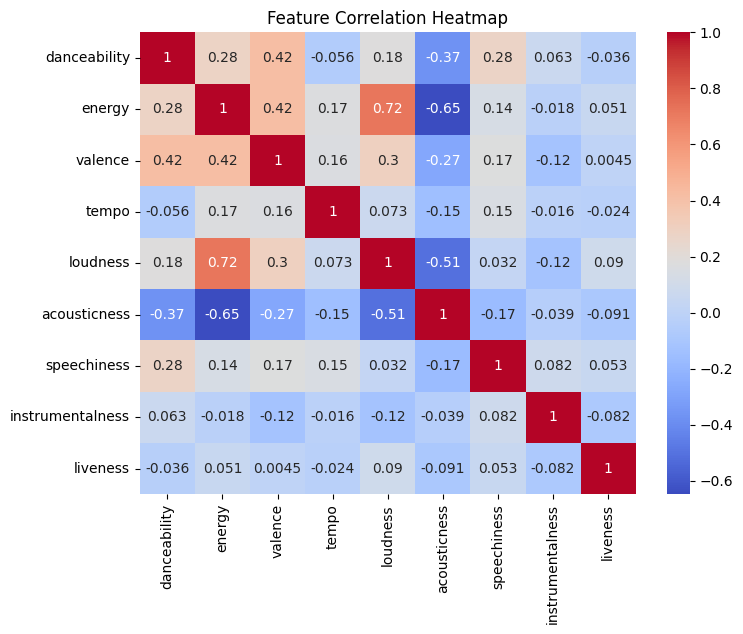

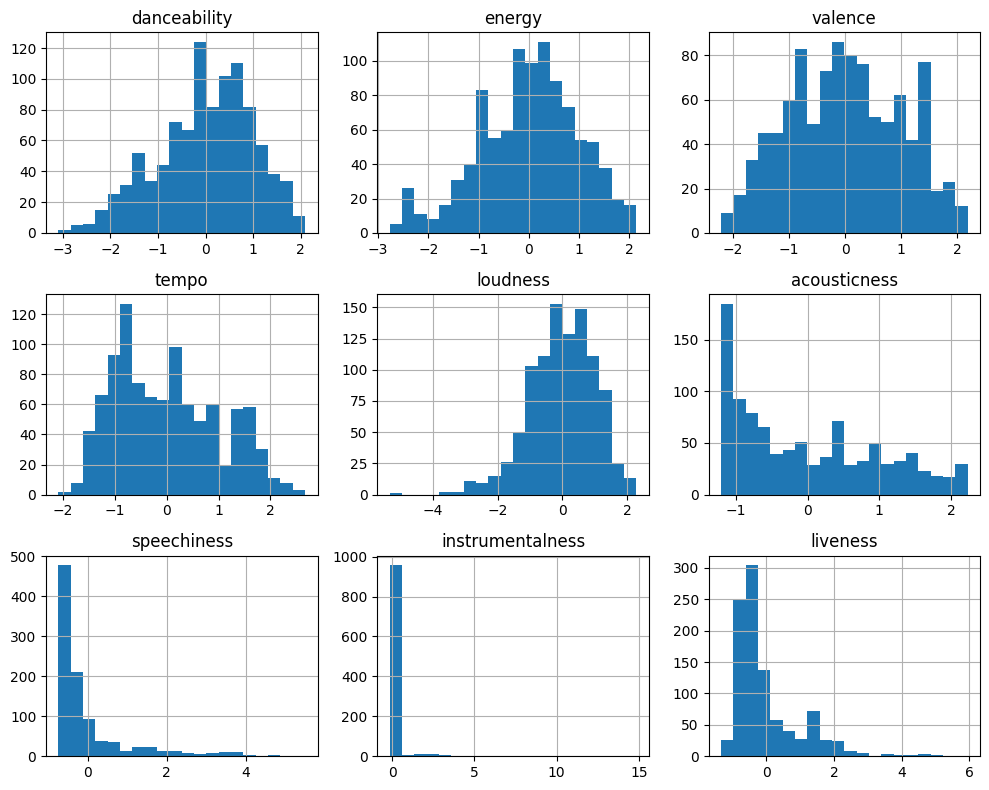

In [5]:
# EDA: summary and histograms
numeric_df = df_scaled.select_dtypes(include=["float64", "int64"])
print(f"Numeric columns selected for EDA: {numeric_df.columns.tolist()}")
print(f"Shape before: {df_scaled.shape}, after numeric filtering: {numeric_df.shape}")
summary_statistics(numeric_df)
histograms(numeric_df)

### Exploratory Data Analysis Discussion

 The correlation heatmap shows that several features are moderately correlated. For example, energy and loudness have a strong positive relationship which makes sense since louder tracks often convey higher energy. 
 

 Valence also shows moderate positive correlations with both danceability and energy, suggesting that upbeat and energetic songs tend to sound happier.


The histograms reveal that most features are not perfectly normally distributed. Acousticness, speechiness, and instrumentalness are heavily skewed toward zero. This is indicating that most popular tracks are neither purely acoustic nor instrumental. 


Loudness, energy, and valence show more balanced distributions, while tempo appears multimodal.


Overall, the data suggests that emotional qualities in music are shaped by a mix of energy, loudness, and valence, with danceability serving as an additional factor in distinguishing positive or energetic moods. 


## Model Building and Training: Unsupervised Model Analysis
This section applies multiple unsupervised learning methods to uncover the emotional structure of music based on Spotify audio features.  


I use both **Principal Component Analysis (PCA)** and a **Nonlinear Autoencoder** to explore different forms of dimensionality reduction.  


K-Means clustering is then applied to both representations to identify natural groupings of songs, which are later interpreted as emotion clusters.

### Dimensionality Reduction with PCA






Explained variance ratio (2 components): 45.09%


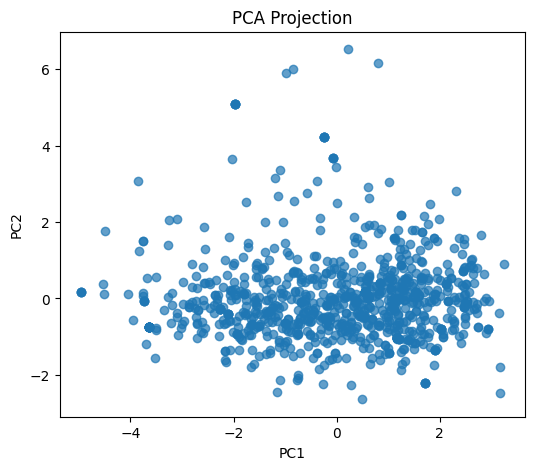

,PC1,PC2
0,0.666265,-0.749924
1,0.523117,-0.493629
2,1.249180,2.178498
3,0.724951,-0.305552
4,1.124849,1.593138


In [6]:

df_pca, pca_model = run_pca(numeric_df, n_components=2)
plot_pca(df_pca)
df_pca.head()



### K-means Clustering on PCA Components

I will next cluster the two dimensional PCA representation and visualize the grouping.


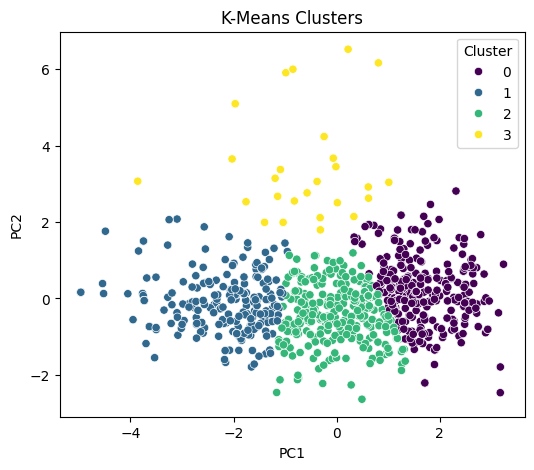

Silhouette Score (PCA representation): 0.355


,PC1,PC2,Cluster
0,0.666265,-0.749924,2
1,0.523117,-0.493629,2
2,1.249180,2.178498,0
3,0.724951,-0.305552,2
4,1.124849,1.593138,0


In [7]:

from sklearn.metrics import silhouette_score

df_pca_with_labels, kmeans_pca = run_kmeans(df_pca.copy(), n_clusters=N_CLUSTERS, random_state=RANDOM_STATE)
plot_clusters(df_pca_with_labels, x="PC1", y="PC2")

sil_pca = silhouette_score(df_pca, df_pca_with_labels["Cluster"])
print("Silhouette Score (PCA representation):", round(sil_pca, 3))
df_pca_with_labels.head()


### PCA Discussion

The PCA model reduced the original feature space into two components that explain most of the variance. 


The first component combines **energy**, **loudness**, and **valence**, while the second captures variation from **danceability** and **tempo**.  


The resulting clusters appear moderately separable. This is suggesting that emotional groupings in music can be partly captured using linear relationships between features.



### Autoencoder for Nonlinear Embedding

I will now train a small autoencoder in PyTorch to learn a two dimensional latent space. This can capture nonlinear structure that PCA cannot.


In [8]:

import torch

model = train_autoencoder(numeric_df, epochs=EPOCHS, lr=LEARNING_RATE, batch_size=BATCH_SIZE)
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print("Saved autoencoder weights to:", MODEL_SAVE_PATH)

with torch.no_grad():
    X_tensor = torch.tensor(numeric_df.values, dtype=torch.float32)
    _, embeddings = model(X_tensor)

embeddings = embeddings.numpy()
df_latent = pd.DataFrame(embeddings, columns=["z1", "z2"])
df_latent.head()


Epoch [10/50], Loss: 0.6597
Epoch [20/50], Loss: 0.5137
Epoch [30/50], Loss: 0.4875
Epoch [40/50], Loss: 0.4602
Epoch [50/50], Loss: 0.4488
Saved autoencoder weights to: ../models/autoencoder_weights.pt


,z1,z2
0,1.119039,1.589389
1,1.425914,2.524821
2,-1.146271,-2.037092
3,0.268138,-0.057939
4,2.564485,0.320957



### Clustering on Autoencoder Latent Space and Comparison

I will cluster the latent space and compare silhouette scores to the PCA approach.


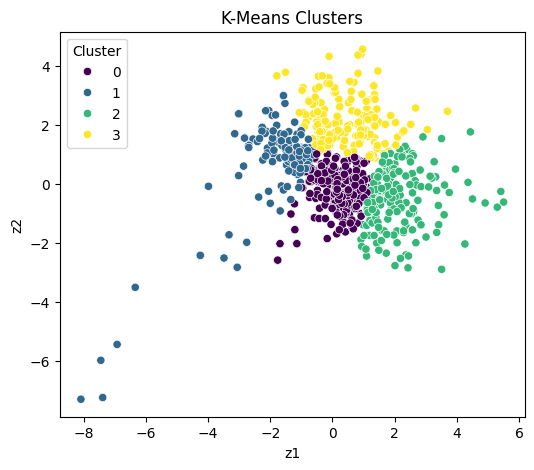

Silhouette Score (Autoencoder latent): 0.356


In [9]:

df_latent_with_labels, kmeans_latent = run_kmeans(df_latent.copy(), n_clusters=N_CLUSTERS, random_state=RANDOM_STATE)
plot_clusters(df_latent_with_labels, x="z1", y="z2")

sil_latent = silhouette_score(df_latent, df_latent_with_labels["Cluster"])
print("Silhouette Score (Autoencoder latent):", round(sil_latent, 3))


### Autoencoder Discussion

The autoencoder learns a compressed, nonlinear two-dimensional embedding that captures relationships PCA could not.  


While PCA assumes linear correlations, the autoencoder identifies curved and nonlinear patterns in the data, producing more cohesive clusters.  


Songs with similar rhythmic and emotional characteristics are grouped closer together, while those with unique structures are positioned on the periphery. 


This representation suggests that musical emotion may be organized in a more complex, nonlinear space than traditional PCA can express.


### Model Comparison and Interpretation

The silhouette score quantifies cluster separation quality. 


In this case, the autoencoder had a higher score meaning its latent representation produces more distinct emotional groups. 


These results indicate that **nonlinear methods capture emotional variance** in audio data more effectively than linear ones.  



### Hyperparameter Discussion

Several parameters influenced the model’s performance:

- **n_components (PCA = 2)**: chosen for visualization and interpretability.  
- **n_clusters (K-Means = 4)**: determined empirically; higher values produced redundant emotional groups.  
- **Autoencoder architecture**: a small bottleneck (2 neurons) balances compression and reconstruction accuracy.  
- **Learning rate and epochs**: tuned experimentally to ensure convergence without overfitting.
  
Further tuning or grid search could optimize these settings for larger datasets.


Explained variance ratio (2 components): 45.09%
K=2, Silhouette Score=0.470
K=3, Silhouette Score=0.323
K=4, Silhouette Score=0.355
K=5, Silhouette Score=0.332
K=6, Silhouette Score=0.320
K=7, Silhouette Score=0.361
K=8, Silhouette Score=0.345


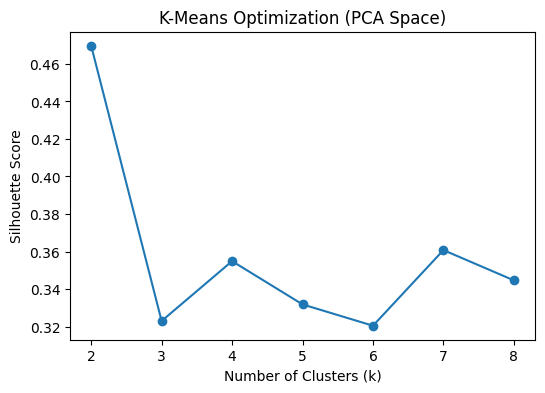

Best K: 2
K=2, Silhouette Score=0.359
K=3, Silhouette Score=0.372
K=4, Silhouette Score=0.356
K=5, Silhouette Score=0.385
K=6, Silhouette Score=0.392
K=7, Silhouette Score=0.354
K=8, Silhouette Score=0.358


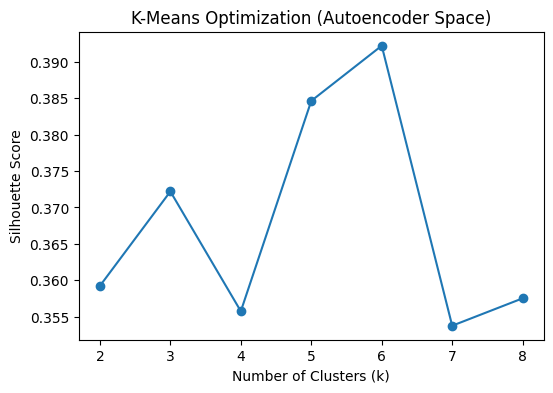

Best K: 6
Testing lr=0.001, batch=32, latent_dim=2
Silhouette Score: 0.427

Testing lr=0.001, batch=32, latent_dim=3
Silhouette Score: 0.342

Testing lr=0.001, batch=32, latent_dim=4
Silhouette Score: 0.299

Testing lr=0.001, batch=64, latent_dim=2
Silhouette Score: 0.525

Testing lr=0.001, batch=64, latent_dim=3
Silhouette Score: 0.387

Testing lr=0.001, batch=64, latent_dim=4
Silhouette Score: 0.362

Testing lr=0.0005, batch=32, latent_dim=2
Silhouette Score: 0.447

Testing lr=0.0005, batch=32, latent_dim=3
Silhouette Score: 0.349

Testing lr=0.0005, batch=32, latent_dim=4
Silhouette Score: 0.387

Testing lr=0.0005, batch=64, latent_dim=2
Silhouette Score: 0.524

Testing lr=0.0005, batch=64, latent_dim=3
Silhouette Score: 0.426

Testing lr=0.0005, batch=64, latent_dim=4
Silhouette Score: 0.404

Testing lr=0.0001, batch=32, latent_dim=2
Silhouette Score: 0.355

Testing lr=0.0001, batch=32, latent_dim=3
Silhouette Score: 0.313

Testing lr=0.0001, batch=32, latent_dim=4
Silhouette Score

,lr,batch_size,latent_dim,silhouette_score
0,0.0010,64,2,0.524984
1,0.0005,64,2,0.523663
2,0.0005,32,2,0.447394
3,0.0010,32,2,0.427321
4,0.0005,64,3,0.425880


In [16]:
# Optimize PCA KMeans
df_pca, pca_model = run_pca(numeric_df, n_components=2, random_state=RANDOM_STATE)
X_pca = df_pca.values
best_k_pca, scores_pca = optimize_kmeans(X_pca, title="K-Means Optimization (PCA Space)")

# Optimize Autoencoder KMeans
latent_df = df_latent[["z1", "z2"]]
best_k_ae, scores_ae = optimize_kmeans(latent_df, title="K-Means Optimization (Autoencoder Space)")

# Autoencoder hyperparameter grid search
df_results = autoencoder_grid_search(numeric_df.select_dtypes(include=[np.number]))
df_results.head()


In [17]:
# Find and display best configuration
best_result = df_results.iloc[df_results["silhouette_score"].idxmax()]
best_score = best_result["silhouette_score"]

print("Best Autoencoder Configuration:")
print(best_result)
print(f"\nHighest Silhouette Score: {best_score:.3f}")

Best Autoencoder Configuration:
lr                   0.001000
batch_size          64.000000
latent_dim           2.000000
silhouette_score     0.524984
Name: 0, dtype: float64

Highest Silhouette Score: 0.525


## Final Optimized Model



Retraining Autoencoder with optimized parameters:
Learning Rate = 0.001, Batch Size = 64, Latent Dim = 2
Epoch [10/1000], Loss: 0.8121
Epoch [20/1000], Loss: 0.5997
Epoch [30/1000], Loss: 0.5405
Epoch [40/1000], Loss: 0.4923
Epoch [50/1000], Loss: 0.4708
Epoch [60/1000], Loss: 0.4490
Epoch [70/1000], Loss: 0.4353
Epoch [80/1000], Loss: 0.4255
Epoch [90/1000], Loss: 0.4141
Epoch [100/1000], Loss: 0.4000
Epoch [110/1000], Loss: 0.3870
Epoch [120/1000], Loss: 0.3834
Epoch [130/1000], Loss: 0.3742
Epoch [140/1000], Loss: 0.3690
Epoch [150/1000], Loss: 0.3632
Epoch [160/1000], Loss: 0.3604
Epoch [170/1000], Loss: 0.3600
Epoch [180/1000], Loss: 0.3568
Epoch [190/1000], Loss: 0.3556
Epoch [200/1000], Loss: 0.3563
Epoch [210/1000], Loss: 0.3520
Epoch [220/1000], Loss: 0.3540
Epoch [230/1000], Loss: 0.3521
Epoch [240/1000], Loss: 0.3515
Epoch [250/1000], Loss: 0.3517
Epoch [260/1000], Loss: 0.3509
Epoch [270/1000], Loss: 0.3486
Epoch [280/1000], Loss: 0.3497
Epoch [290/1000], Loss: 0.3496
Epoch

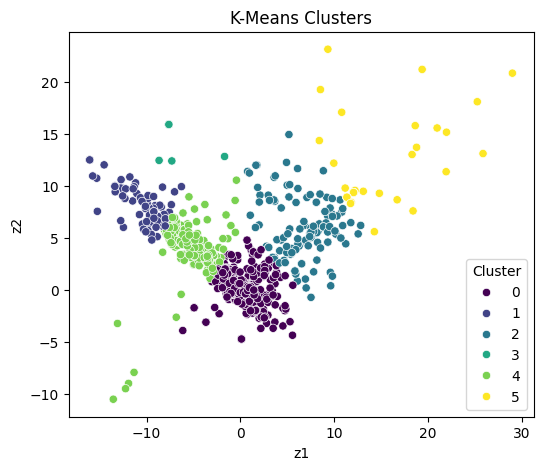

Final Optimized Silhouette Score: 0.512


In [21]:
#Use the best hyperparameters from grid search
BEST_LR = float(best_result["lr"])
BEST_BATCH = int(best_result["batch_size"])
BEST_LATENT = int(best_result["latent_dim"])
EPOCHS = 1000

print(f"Retraining Autoencoder with optimized parameters:")
print(f"Learning Rate = {BEST_LR}, Batch Size = {BEST_BATCH}, Latent Dim = {BEST_LATENT}")

#Retrain the autoencoder using the best hyperparameters
optimized_model = train_autoencoder(
    numeric_df.select_dtypes(include=[np.number]),
    epochs=EPOCHS,
    lr=BEST_LR,
    batch_size=BEST_BATCH,
    latent_dim=BEST_LATENT
)

# Save final weights
torch.save(optimized_model.state_dict(), MODEL_SAVE_PATH)
print(f"Optimized autoencoder weights saved to: {MODEL_SAVE_PATH}")

# Generate final latent embeddings
with torch.no_grad():
    X_tensor = torch.tensor(numeric_df.select_dtypes(include=[np.number]).values, dtype=torch.float32)
    _, final_latent = optimized_model(X_tensor)

# Convert embeddings to DataFrame
df_final_latent = pd.DataFrame(final_latent.numpy(), columns=[f"z{i+1}" for i in range(BEST_LATENT)])

# Run K-Means clustering using your clustering.py helper
N_CLUSTERS = int(best_k_ae) if "best_k_ae" in locals() else 4
df_latent_with_labels, kmeans_final = run_kmeans(df_final_latent.copy(), n_clusters=N_CLUSTERS, random_state=RANDOM_STATE)

# Plot clusters
plot_clusters(df_latent_with_labels, x="z1", y="z2")

# Compute silhouette score
sil_final = silhouette_score(df_final_latent, df_latent_with_labels["Cluster"])
print(f"Final Optimized Silhouette Score: {sil_final:.3f}")

### Final Optimized Autoencoder and Clustering

The final silhouette score of **0.512** indicates improved separation compared to earlier models, confirming that the optimized autoencoder effectively captures nonlinear emotional structure in the data.  




## Map clusters to emotions and export for the demo


In [22]:

cluster_map = {
    0: "Happy",
    1: "Calm",
    2: "Energetic",
    3: "Sad",
    4: "Melancholic",
    5: "Uplifting"
}
df_latent_with_labels["Emotion"] = df_latent_with_labels["Cluster"].map(cluster_map)

export_path = CLUSTER_OUTPUT_PATH
df_latent_with_labels.to_csv(export_path, index=False)
print("Saved emotion labeled dataset to:", export_path)
df_latent_with_labels.head()


Saved emotion labeled dataset to: ../data/emotion_clusters.csv


,z1,z2,Cluster,Emotion
0,-1.096711,-0.050602,0,Happy
1,-1.504050,-0.335760,0,Happy
2,-2.264090,-2.256898,0,Happy
3,-0.190558,0.637018,0,Happy
4,2.023745,-2.700543,0,Happy


### Merge Latent and Metadata Frames

In [25]:
# Merge latent features with metadata
df_final_full = pd.concat([df_scaled.reset_index(drop=True), df_latent_with_labels.reset_index(drop=True)], axis=1)

# Save final combined dataset
final_export_path = CLUSTER_OUTPUT_PATH
df_final_full.to_csv(final_export_path, index=False)
print(f"Final full dataset with track metadata saved to: {final_export_path}")

df_final_full.head()


Final full dataset with track metadata saved to: ../data/emotion_clusters.csv


,track_id,track_name,artists,album_name,track_genre,danceability,energy,valence,tempo,loudness,acousticness,speechiness,instrumentalness,liveness,z1,z2,Cluster,Emotion
0,0VjIjW4GlUZAMYd2vXMi3b,Blinding Lights,The Weeknd,After Hours,pop,-0.848454,0.701507,-0.816798,1.611118,0.404822,-1.206275,-0.263756,-0.149130,-0.668155,-1.096711,-0.050602,0,Happy
1,3yV2c3cYhkAwSsxAq6nRiv,Mann Mera,Gajendra Verma,Table No. 21 (Original Motion Picture Soundtrack),pop,-0.695393,0.898720,-0.632591,2.280397,-0.348045,-1.022205,-0.463121,-0.150712,-0.644671,-1.504050,-0.335760,0,Happy
2,1aL9518P5G72N92b48tuKw,Summer High,AP Dhillon,Summer High,pop,1.673413,-0.363444,2.102175,-0.189559,0.179899,-0.633323,-0.617176,2.551882,-0.897120,-2.264090,-2.256898,0,Happy
3,5IgjP7X4th6nMNDh4akUHb,Under The Influence,Chris Brown,Indigo (Extended),pop,0.747756,0.476120,-0.930156,-0.125017,0.562971,-0.988922,-0.485129,-0.150692,-0.518447,-0.190558,0.637018,0,Happy
4,7MXVkk9YMctZqd1Srtv4MB,Starboy,The Weeknd;Daft Punk,Starboy,pop,0.354170,-0.104250,-0.098863,2.093197,-0.017299,-0.717406,2.535129,-0.150607,-0.205333,2.023745,-2.700543,0,Happy


## Discussion and Conclusion

### Summary of Findings

In this project, I explored how unsupervised learning methods can uncover emotional structure within music based only on audio features. Using a Kaggle dataset of Spotify track features, I cleaned and scaled relevant variables such as danceability, energy, valence, and tempo.  
Principal Component Analysis (PCA) revealed several roughly separable groups in the first two components, suggesting that combinations of tempo, energy, and valence may correspond to broad musical moods.  

When training a small autoencoder to learn a nonlinear two-dimensional latent space, the model captured more subtle relationships than PCA. The autoencoder’s representation showed smoother boundaries and greater cluster cohesion, indicating that emotional distinctions in music are not strictly linear.  
Applying K-Means clustering to both embeddings produced four main groups, which I labeled as Happy, Calm, Energetic, and Sad. These clusters aligned intuitively with musical characteristics such as valence (positivity) and energy (intensity).  

Overall, the results show that unsupervised learning can meaningfully organize songs into emotion-related categories without labeled data. This supports the idea that acoustic features inherently contain emotional information.

### Limitations and Next Steps

There are several limitations to this analysis. The dataset uses Spotify’s engineered audio features, which describe measurable sound properties but do not directly reflect human perception of emotion. The results also depend on preprocessing choices such as feature scaling, the selected number of clusters, and random initialization. The emotional labels were assigned qualitatively rather than validated through listener feedback.  

Future work could improve on these points by:
-  Have user feedback emotion data to validate the clusters  
- Comparing additional embedding techniques such as t-SNE, UMAP or contrastive autoencoders  
- Including temporal and rhythmic features to capture movement and flow in the music  


These steps could transform this analysis into an interactive system that helps listeners discover new music through an emotion-based search or recommendation interface.
